In [ ]:
#import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
#import nltk
from sklearn.preprocessing import LabelBinarizer
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import word_tokenize,sent_tokenize
#from bs4 import BeautifulSoup
import re,string,unicodedata

#from nltk.tokenize.toktok import ToktokTokenizer

from string import punctuation
#from nltk import pos_tag
#from nltk.corpus import wordnet
#import keras

#import tensorflow as tf
import pickle

In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)

In [ ]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
df.drop('article_link',axis = 1,inplace = True)

with open('sarcasm.pickle','wb') as f:
    pickle.dump(df,f)

In [ ]:
with open('/content/sample_data/sarcasm.pickle','rb') as f:
      df = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
df.drop('article_link',axis =1, inplace=True)

KeyError: ignored

In [ ]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


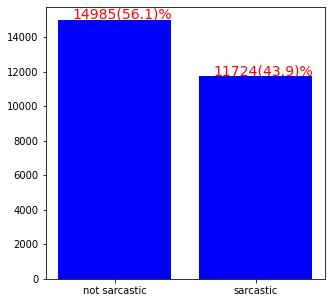

In [ ]:
fig,ax = plt.subplots(figsize =(5,5))
y=df.is_sarcastic.value_counts()
plt.bar(y.index,y.values,tick_label=['not sarcastic','sarcastic'],color='blue')
for i, v in y.items():
    ax.text(i-.3, 
              v+300, 
              str(v)+"("+str(round(v*100/(len(df)),2))+")%",va='center',fontsize=14,color='red')

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words_orig = nlp.Defaults.stop_words
  

In [ ]:
nlp.vocab['not'].is_stop

True

In [ ]:
nlp.Defaults.stop_words.remove('not')

In [ ]:
stop_words_orig = nlp.Defaults.stop_words.union(set(list(punctuation)))

In [ ]:
for pun in list(punctuation):
    nlp.vocab[pun].is_stop = True
nlp.vocab['not'].is_stop = False    
    

In [ ]:
df2 = df.iloc[:1000,:]

In [ ]:
docs = list(nlp.pipe(df['headline'], disable = ['tagger','parser']) )


In [ ]:
doc = docs[0]


In [ ]:
def remove_stopwords(doc):
     x = [token.text for token in doc if not(token.is_stop)] 
     return ' '.join(x).strip()        

In [ ]:
df2 = df
df2['transformed'] = pd.Series(docs).apply(remove_stopwords)

In [ ]:
def display_wordcloud(categories = 2):
    plt.figure(figsize = (20,10))
    d ={0:'Not sarcastic',1:'Sarcastic'}
    for t in range(categories):
        i=t+1
        plt.subplot(categories,1, i).set_title(d[t],fontsize=16)
        plt.imshow(WordCloud(height =450, width =900, background_color='whitesmoke').generate_from_text(' '.join(df2[df2.is_sarcastic==t].headline.tolist())),interpolation ='nearest')
        plt.axis("off")
    plt.show()

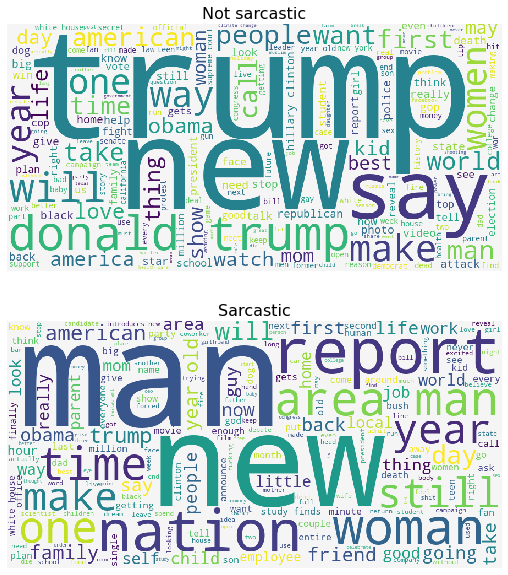

In [ ]:
display_wordcloud()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
texts=df2[df2.is_sarcastic==0].headline
cv = CountVectorizer()
cv_fit=cv.fit_transform(texts)
words_list = cv.get_feature_names()
counts_list = list(cv_fit.toarray().sum(axis=0))
#print (sorted(cv.vocabulary_))


In [ ]:
#print (sorted(cv.vocabulary_))
from collections import OrderedDict
dd = OrderedDict(sorted(zip(words_list,counts_list), key=lambda x: x[1],reverse =True))
uni = len(dd)

In [ ]:
plt.bar(*zip(*dd.items()))
plt.show()

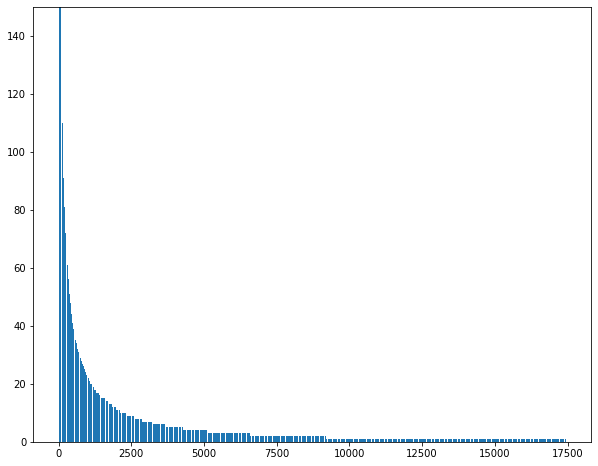

In [ ]:
counts_sorted_list = list(dd.values())
fig = plt.figure(figsize=(10,8))
plt.bar(range(0,uni),[counts_sorted_list[x] for x in range(0,uni)])
plt.ylim(0,150)
plt.show()

Proving Zip's Law

In [ ]:
plt.loglog(range(0,uni),[counts_sorted_list[x] for x in range(0,uni)],c='red')
plt.show()


NameError: ignored

Model 1 - Will train word2vec using input text corpora

In [ ]:
#Generate inputs for word2vec model -- LIL words
w2v_input2=[]
for doc in docs:
    w2v_input2.append([token.text for token in doc if token.text.strip() and not(token.is_stop) ])

In [ ]:
len(w2v_input2)

26709

In [ ]:
import numpy as np
np.where(w2v_input2=='trump')


(array([], dtype=int64),)

In [ ]:
import gensim
#Dimension of embedded vectors- Hyperparameter to tune later--initial value-50
emb_dim =50

#Create w2v embeddings(CBOW) using training data only
w2v = gensim.models.Word2Vec(w2v_input2 , size=emb_dim , window = 5 , min_count = 1)


In [ ]:
import warnings   
warnings.filterwarnings(action = 'ignore') 
w2v.wv.similarity('queen','king')

0.9994529

In [ ]:
w2v_skipgram = gensim.models.Word2Vec(w2v_input2 , size=emb_dim , window = 5 ,sg=1, min_count = 1)

In [ ]:
w2v_skipgram.wv.similarity('king','queen')

0.24034601

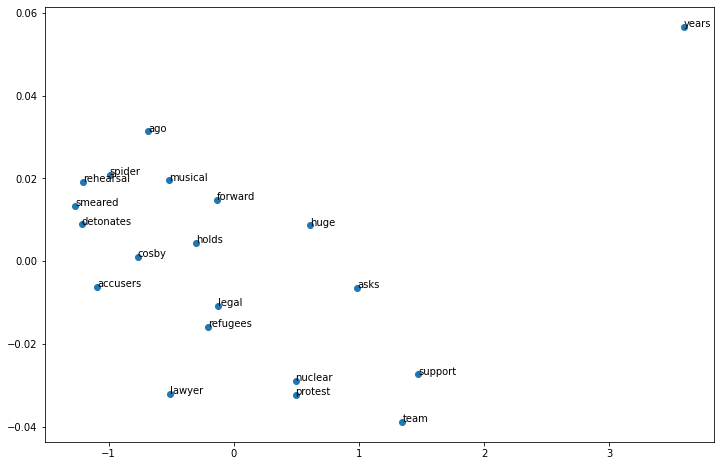

In [ ]:
from sklearn.decomposition import PCA
X = w2v[list(w2v.wv.vocab)[100:120]]
#X = w2v['mother','father','modi','trump','kid','usa','india','congress','refugees','red','green','black','white']
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
fig = plt.figure(figsize=(12,8))
plt.scatter(result[:, 0], result[:, 1])
words = list(w2v.wv.vocab)[100:120]
#words = ['mother','father','modi','trump','kid','usa','india','congress','refugees','red','green','black','white']
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Finding the maximum size of the news in our dataset

In [ ]:
max_length = max(list(map(len,w2v_input2))) 

In [ ]:
max_length

35

In [ ]:
len(w2v.wv.vocab)
w2v.wv.get_vector(' ')


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tr = Tokenizer(num_words=25000)
tr.fit_on_texts(w2v_input2)
tokenised_seq = tr.texts_to_sequences(w2v_input2)
tok_pad_seq = pad_sequences(tokenised_seq, maxlen = max_length, padding = 'pre',truncating = 'pre')
#After padding we will have the output of shape m(no of examples) X time-steps(maxlen) 

Using TensorFlow backend.


In [ ]:
np.max(tok_pad_seq)

24999

We will set the initial values of the weight matrix to the values received from Gensim's Word2Vec model trained on our input data. Shape of weight matrix is (vocab_size(plus 1 for 'unknown' terms) X embedding_dim(50))

In [ ]:

import numpy as np
def get_weight_matrix(w2v_model, word_to_index, emb_dim, vocab_size):
    weights = np.zeros((vocab_size,emb_dim))
    for wrd, idx in word_to_index.items():
         try:
            weights[idx]= w2v_model[wrd]
         except:
            weights[idx] = np.zeros((1,50))   
    return weights 


In [ ]:
np.zeros((1,2))

array([[0., 0.]])

In [ ]:
len(tr.word_index)

25590

In [ ]:
vocab_size = 1+len(tr.index_word)
weight_matrix = get_weight_matrix(w2v, tr.word_index, emb_dim,vocab_size)

In [ ]:
vocab_size

25591

In [ ]:
weight_matrix[:2,:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.62130082,  1.36676812,  0.11887544,  0.05056489, -2.12269044,
        -0.24194762, -0.23286134,  0.31668463, -0.53807396, -1.4910804 ]])

Let us use a bidirectional LSTM with 2 layers with RMSprop optimiser and we shall determine its accuracy. We would also train the embedded vectors along with training the parameters of weight and bias. We have taken their initial values from our train data using Gensim's Word2vec model 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from keras.optimizers import RMSprop

embedding = Embedding(vocab_size, output_dim=emb_dim, weights=[weight_matrix], input_length=max_length, trainable=True)
def compile_model(embedding):
    model = Sequential()
    model.add(embedding)
    model.add(Bidirectional(LSTM(units=128 , return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=32 , return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=RMSprop(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
max_length

35

In [ ]:
model = compile_model(embedding)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 50)            1279550   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 256)           183296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,536,895
Trainable params: 1,536,895
Non-trainable params: 0
____________________________________________

We have converted the dataframe into padded and tokenised sequences. Let us divide it into train and test subset for model evaluation

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(tok_pad_seq,df['is_sarcastic'],test_size = 0.3, random_state = 1)
def fit_model():
    return model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs = 5 ,batch_size = 1024, use_multiprocessing = False )
m1 = fit_model()

Train on 18696 samples, validate on 8013 samples
Epoch 1/5
18696/18696 [==============================] - 44s 2ms/step - loss: 0.7554 - accuracy: 0.5550 - val_loss: 0.6784 - val_accuracy: 0.5643
Epoch 2/5
18696/18696 [==============================] - 43s 2ms/step - loss: 0.6064 - accuracy: 0.6874 - val_loss: 0.7109 - val_accuracy: 0.5269
Epoch 3/5
18696/18696 [==============================] - 43s 2ms/step - loss: 0.4581 - accuracy: 0.7933 - val_loss: 0.6454 - val_accuracy: 0.7135
Epoch 4/5
18696/18696 [==============================] - 43s 2ms/step - loss: 0.3159 - accuracy: 0.8774 - val_loss: 0.7345 - val_accuracy: 0.7178
Epoch 5/5
18696/18696 [==============================] - 43s 2ms/step - loss: 0.2111 - accuracy: 0.9255 - val_loss: 0.6918 - val_accuracy: 0.7482


In [ ]:
test_loss, test_acc = model.evaluate(X_test,Y_test)
train_loss, train_acc = model.evaluate(X_train,Y_train)
print("test_loss",test_loss, '\ntest_acc' ,test_acc,'\ntrain_loss',train_loss, '\ntrain_acc',train_acc)

18696/18696 [==============================] - 14s 773us/step
test_loss 0.6917551304760549 
test_acc 0.7481592297554016 
train_loss 0.10681142241311063 
train_acc 0.9678540825843811


In [ ]:
model.predict(X_test[:10])

In [ ]:
model.predict_classes(X_test[:10],)

In [ ]:
def display_loss_acc(history,categories = 2):
    plt.figure(figsize = (20,10))
    epochs = list(range(5))
    d ={0:['Accuracy','accuracy','val_accuracy'],1:['Loss','loss','val_loss']}
    for t in range(categories):
        i=t+1
        plt.subplot(1, categories, i).set_title(d[t][0],fontsize=20)
        plt.plot(epochs,list(history.history[d[t][1]]), color = 'blue',label = 'Train set' )
        plt.plot(epochs,list(history.history[d[t][2]]), color = 'red' ,label ='Validation set')
        plt.legend(fontsize = 20)

    plt.show()

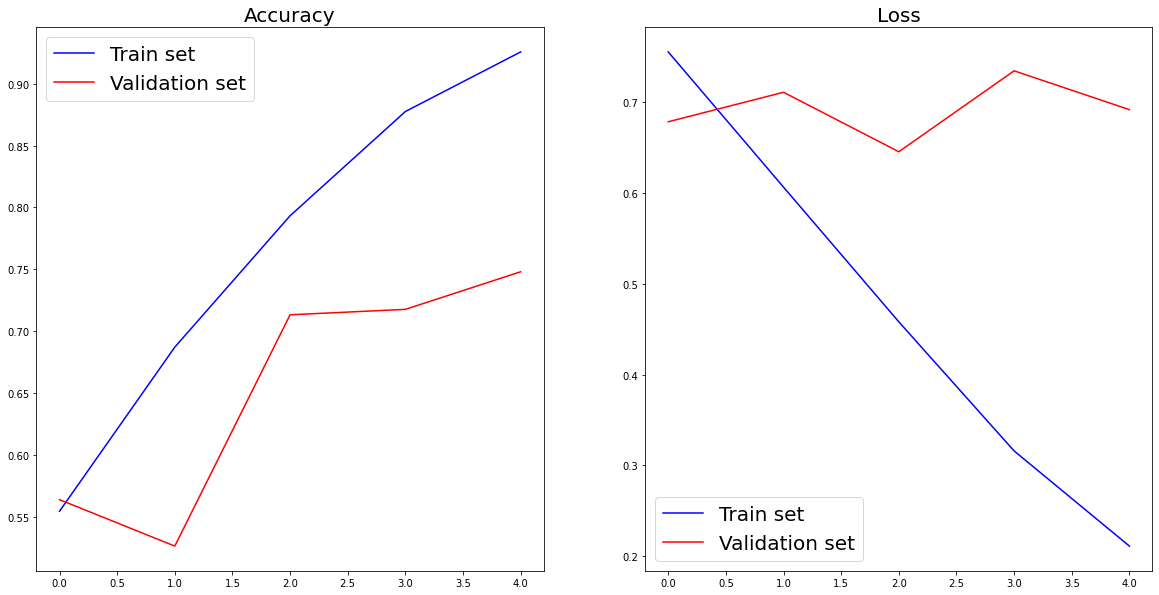

In [ ]:
display_loss_acc(m1)

In [ ]:
m1.history

{'accuracy': [0.55830127, 0.7706996, 0.87451863],
 'loss': [0.69505405579054, 0.5097074579825297, 0.31446075825212755],
 'val_accuracy': [0.6161237955093384, 0.7227005958557129, 0.7786097526550293],
 'val_loss': [0.6535744781085321, 0.5417909323611272, 0.5439918410401657]}

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,auc
from seaborn import heatmap

y_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_test,y_pred)
print (cm)
plt.figure(figsize =(8,6))
heatmap(cm, annot = True, cmap = 'BuGn', fmt ='')

Using Glove vectors

In [ ]:
with open('glove.6B.50d.txt') as f:
   lines = f.readlines()
   print(lines[3:4])

['of 0.70853 0.57088 -0.4716 0.18048 0.54449 0.72603 0.18157 -0.52393 0.10381 -0.17566 0.078852 -0.36216 -0.11829 -0.83336 0.11917 -0.16605 0.061555 -0.012719 -0.56623 0.013616 0.22851 -0.14396 -0.067549 -0.38157 -0.23698 -1.7037 -0.86692 -0.26704 -0.2589 0.1767 3.8676 -0.1613 -0.13273 -0.68881 0.18444 0.0052464 -0.33874 -0.078956 0.24185 0.36576 -0.34727 0.28483 0.075693 -0.062178 -0.38988 0.22902 -0.21617 -0.22562 -0.093918 -0.80375\n']


Instead of reading entire file and searching for vectors corresponding to words one by one, we will use gensim to convert glove to word2vec

In [ ]:
from gensim.models import  KeyedVectors
from gensim.scripts.glove2word2vec import  glove2word2vec
w2v_file = 'glove_w2v.txt'
glove_file = 'glove.6B.50d.txt'
glove2word2vec(glove_file, w2v_file)



(400000, 50)

In [ ]:
glove_model = KeyedVectors.load_word2vec_format(w2v_file,binary= False)


In [ ]:
result = glove_model.most_similar(positive=['actor', 'male'], negative=['man'], topn=1)
print(result)

[('actresses', 0.7384971380233765)]


In [ ]:
weight_matrix_glove = get_weight_matrix(glove_model, tr.word_index, emb_dim,vocab_size)


In [ ]:
with open('weight_matrix_glove.pickle','wb') as f:
      pickle.dump(weight_matrix_glove,f)

In [ ]:
def compile_model(embedding):
    model = Sequential()
    model.add(embedding)
    model.add(Bidirectional(LSTM(units=128 , return_sequences = True)))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(units=32 , return_sequences=False)))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=RMSprop(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
embedding = Embedding(vocab_size, output_dim=emb_dim, weights=[weight_matrix_glove], input_length=max_length, trainable=True)

In [ ]:
model = compile_model(embedding)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 50)            1279550   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 35, 256)           183296    
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,536,895
Trainable params: 1,536,895
Non-trainable params: 0
____________________________________________

In [ ]:
m2 = fit_model()

Train on 18696 samples, validate on 8013 samples
Epoch 1/5
18696/18696 [==============================] - 44s 2ms/step - loss: 0.7721 - accuracy: 0.5559 - val_loss: 0.6117 - val_accuracy: 0.6715
Epoch 2/5
18696/18696 [==============================] - 43s 2ms/step - loss: 0.6134 - accuracy: 0.6797 - val_loss: 0.5107 - val_accuracy: 0.7653
Epoch 3/5
18696/18696 [==============================] - 44s 2ms/step - loss: 0.4545 - accuracy: 0.8089 - val_loss: 0.4701 - val_accuracy: 0.7896
Epoch 4/5
18696/18696 [==============================] - 44s 2ms/step - loss: 0.3924 - accuracy: 0.8459 - val_loss: 0.4587 - val_accuracy: 0.8101
Epoch 5/5
18696/18696 [==============================] - 44s 2ms/step - loss: 0.3349 - accuracy: 0.8746 - val_loss: 0.4759 - val_accuracy: 0.8034


In [ ]:
m2 = fit_model()

Train on 18696 samples, validate on 8013 samples
Epoch 1/5
18696/18696 [==============================] - 306s 16ms/step - loss: 0.7217 - accuracy: 0.5622 - val_loss: 0.6306 - val_accuracy: 0.6622
Epoch 2/5
18696/18696 [==============================] - 291s 16ms/step - loss: 0.6098 - accuracy: 0.6871 - val_loss: 0.5918 - val_accuracy: 0.7212
Epoch 3/5
18696/18696 [==============================] - 288s 15ms/step - loss: 0.4825 - accuracy: 0.7852 - val_loss: 0.4834 - val_accuracy: 0.7779
Epoch 4/5
18696/18696 [==============================] - 212s 11ms/step - loss: 0.3361 - accuracy: 0.8601 - val_loss: 0.4522 - val_accuracy: 0.8047
Epoch 5/5
18696/18696 [==============================] - 226s 12ms/step - loss: 0.2429 - accuracy: 0.9044 - val_loss: 0.5070 - val_accuracy: 0.8057


In [ ]:
test_loss, test_acc = model.evaluate(X_test,Y_test)
train_loss, train_acc = model.evaluate(X_train,Y_train)
print("test_loss",test_loss, '\ntest_acc' ,test_acc,'\ntrain_loss',train_loss, '\ntrain_acc',train_acc)

18696/18696 [==============================] - 74s 4ms/step
test_loss 0.5070062391724938 
test_acc 0.8056907653808594 
train_loss 0.1562212113120462 
train_acc 0.9428755044937134


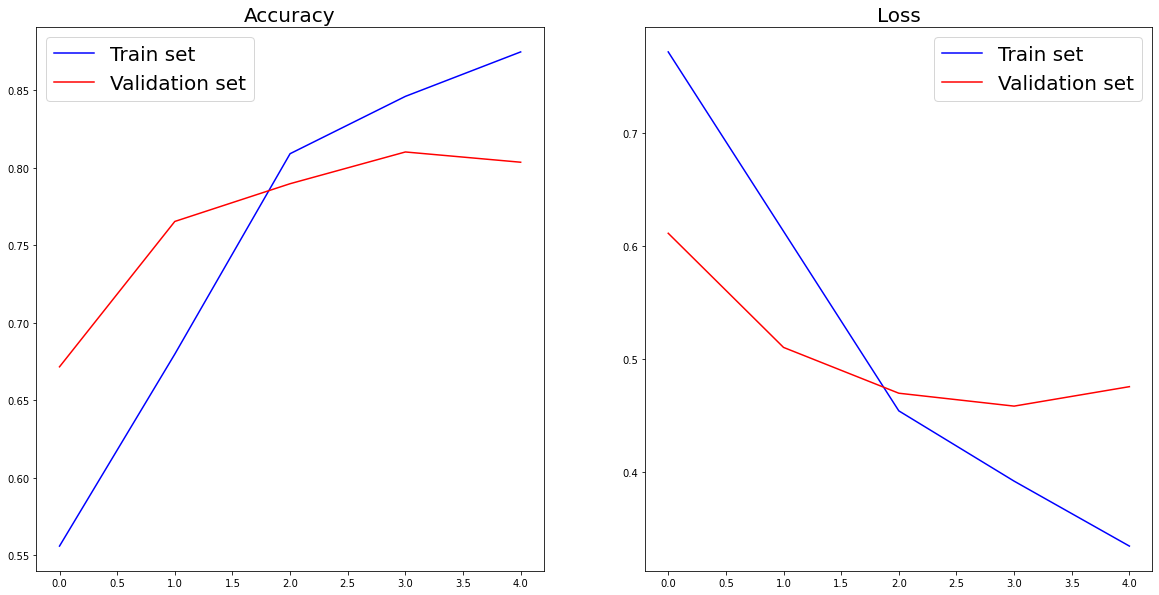

In [ ]:
display_loss_acc(m2)

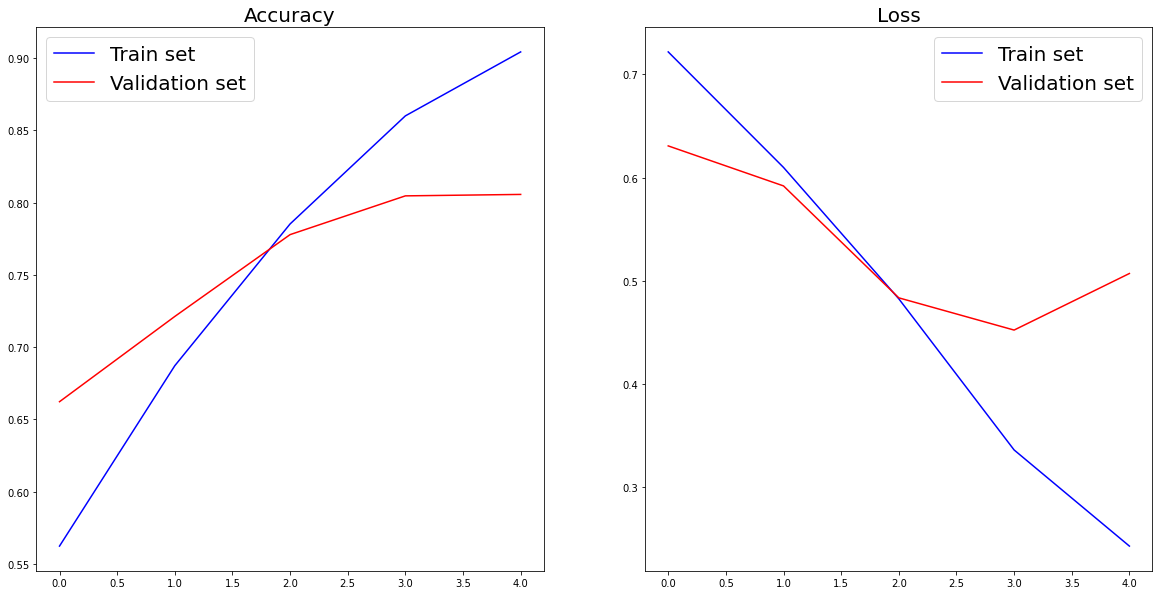

In [ ]:
display_loss_acc(m2)